In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
basedir = './prepped_data/'

In [3]:
%%time
main_data_df = pd.read_csv(basedir + 'main_data_baseline_checkpoint_1.csv')
main_data_df.shape

Wall time: 5.71 s


(4555253, 17)

In [ ]:
%%time
land_plans_df = pd.read_csv(basedir + 'land_plans_ver_2.csv')
land_plans_df.shape

In [ ]:
%%time
bdinfo_df = pd.read_csv(basedir + 'merged_bdinfo_floor_info_features.csv')
bdinfo_df.shape

In [ ]:
%%time
land_prices_df = pd.read_csv(basedir + 'land_prices_ver_2.csv')
land_prices_df.shape

In [4]:
main_data_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소,addr_split_len
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,4.0
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,4.0
2,매매,67.28,11,55000,0,5,1987,817.479191,2013,2,10.915088,6.706225,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0
3,매매,67.28,22,58250,0,4,1987,865.784780,2013,2,10.972499,6.763636,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0
4,매매,67.28,10,60000,0,5,1987,891.795482,2013,5,11.002100,6.793237,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0


In [5]:
nan_df = main_data_df[main_data_df['도로명주소'].isna()]
nan_df.shape

(46345, 17)

In [7]:
nan_df['지번주소'].nunique()

1650

In [7]:
main_data_df.dropna(inplace=True)

In [10]:
san_df = main_data_df[main_data_df['지번주소'].str.contains('산1')]
san_df.shape

(1173, 17)

In [11]:
san_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소,addr_split_len
348901,매매,79.42,2,25000,0,6,1986,314.782171,2013,1,10.126631,5.751881,아파트,서울특별시 금천구 시흥동 산173-8,산,서울특별시 금천구 시흥대로51길 55-0,4.0
348902,매매,55.30,18,17100,0,4,1986,309.222423,2013,1,9.746834,5.734061,아파트,서울특별시 금천구 시흥동 산173-8,산,서울특별시 금천구 시흥대로51길 55-0,4.0
348903,매매,79.42,12,28000,0,10,1986,352.556031,2013,2,10.239960,5.865210,아파트,서울특별시 금천구 시흥동 산173-8,산,서울특별시 금천구 시흥대로51길 55-0,4.0
348904,매매,67.27,15,23700,0,8,1986,352.311580,2013,2,10.073230,5.864516,아파트,서울특별시 금천구 시흥동 산173-8,산,서울특별시 금천구 시흥대로51길 55-0,4.0
348905,매매,55.30,18,18100,0,5,1986,327.305606,2013,2,9.803667,5.790894,아파트,서울특별시 금천구 시흥동 산173-8,산,서울특별시 금천구 시흥대로51길 55-0,4.0


In [4]:
land_plans_df.fillna('해당사항없음', inplace=True)

In [5]:
dfs_list = [main_data_df, land_plans_df, bdinfo_df, land_prices_df]
for df in dfs_list:
    print(df.shape)

(4555253, 17)
(874028, 272)
(718969, 255)
(1594565, 4)


In [6]:
main_data_df.drop(columns=['대장구분명', '도로명주소', 'addr_split_len'], inplace=True)

In [7]:
main_data_df.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)

In [8]:
%%time
main_data_df['전용면적_mean'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('mean')['전용면적']
main_data_df['전용면적_min'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('min')['전용면적']
main_data_df['전용면적_max'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('max')['전용면적']

Wall time: 1.76 s


In [9]:
main_data_df = main_data_df[(main_data_df['전월세매매구분'] == '매매')|(main_data_df['전월세매매구분'] == '전세')].drop(columns=['월세(만원)'])
print(main_data_df.shape)

(3705841, 16)


In [10]:
main_data_df['건물나이'] = main_data_df['년'] - main_data_df['건축년도']
main_data_df['건물나이'].describe()

count    3.705841e+06
mean     1.420577e+01
std      1.002407e+01
min     -1.200000e+01
25%      6.000000e+00
50%      1.300000e+01
75%      2.100000e+01
max      8.900000e+01
Name: 건물나이, dtype: float64

In [11]:
main_data_df['건물나이'] = main_data_df['건물나이']**2
main_data_df['건물나이'].describe()

count    3.705841e+06
mean     3.022858e+02
std      3.576561e+02
min      0.000000e+00
25%      3.600000e+01
50%      1.690000e+02
75%      4.410000e+02
max      7.921000e+03
Name: 건물나이, dtype: float64

In [12]:
main_data_df.rename(columns={'건물나이':'건물나이**2'}, inplace=True)

In [13]:
main_data_df.drop(columns=['건축년도'], inplace=True)

In [14]:
main_data_df['year_linear'] = (main_data_df['년'] - main_data_df['년'].min()) + ((main_data_df['월']-1)/12)

In [15]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [16]:
main_data_df['month_sin'] = main_data_df['월'].apply(month_circular_sine_func)
main_data_df['month_cos'] = main_data_df['월'].apply(month_circular_cosine_func)

In [17]:
main_data_df.drop(columns=['월', '계약일'], inplace=True)

In [19]:
main_data_df['가격/면적'].describe()

count    3.705841e+06
mean     5.104996e+02
std      2.852378e+02
min      2.066340e+01
25%      3.229527e+02
50%      4.464286e+02
75%      6.212858e+02
max      4.426360e+03
Name: 가격/면적, dtype: float64

<AxesSubplot:>

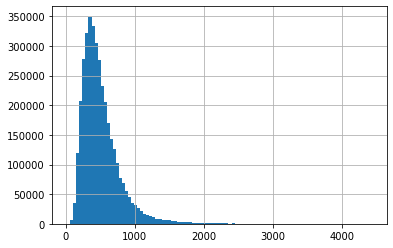

In [18]:
main_data_df['가격/면적'].hist(bins=100)

In [ ]:
merge1_df = main_data_df.merge(land_plans_df, on=['지번주소', '년'])
merge1_df.shape

In [ ]:
bdinfo_df['기준년월'] = bdinfo_df['기준년월'].apply(lambda x:int(str(x)[:4]))
bdinfo_df.rename(columns={'기준년월':'년'}, inplace=True)
bdinfo_df.drop(columns=['기준년월_최초사용승인일', '주소별_최초생성일자'], inplace=True)

In [ ]:
merge2_df = merge1_df.merge(bdinfo_df, on=['지번주소', '년'])
merge2_df.shape

In [ ]:
merge2_df['구'] = merge2_df['지번주소'].apply(lambda x: x.split(' ')[1])
merge2_df['동'] = merge2_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [ ]:
merge3_df = merge2_df.merge(land_prices_df, on=['지번주소', '년'])
merge3_df.shape

In [ ]:
merge3_df['공시지가'] = merge3_df['공시지가'] / 10000
merge3_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [ ]:
merge3_df.drop(columns=['지번주소'], inplace=True)

In [ ]:
merge3_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','') for col in merge3_df.columns]

In [ ]:
land_plans_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','') for col in land_plans_df.columns]

In [ ]:
lp_catcols = land_plans_df.columns.tolist()[2:]

In [ ]:
cat_cols = ['전월세매매구분', '건물종류', '구', '동', '표준지여부'] + lp_catcols + ['최빈지붕', '최빈용도', '최빈구조']

In [ ]:
for col in tqdm(cat_cols):
    col_map = {}
    col_map_df = pd.DataFrame({'cat':merge3_df[col].unique(),'map':[i for i in range(len(merge3_df[col].unique()))]})
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    merge3_df[col] = merge3_df[col].map(col_map)
    col_map_df.to_csv('./Training/training_data_ver_9/feature_maps/{}_map.csv'.format(col))

In [ ]:
merge3_df.head()

In [ ]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']

In [ ]:
cat_cols_df = pd.DataFrame({'colname':cat_cols})
cat_cols_df.head()

In [ ]:
cat_cols_df.to_csv('./Training/training_data_ver_9/cat_cols.csv', index=False)

In [ ]:
len(cat_cols)

In [ ]:
total_cat_cols = cat_cols + [col for col in bdinfo_df.columns if col not in cat_cols + ['지번주소', '년']]
len(total_cat_cols)

In [ ]:
cols_to_drop = []
for col in tqdm(total_cat_cols):
    if (merge3_df[col].value_counts()[0] / merge3_df.shape[0]) > 0.999:
        cols_to_drop.append(col)

In [ ]:
len(cols_to_drop)

In [ ]:
cols_to_drop

In [ ]:
merge3_df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
%%time
merge3_df.to_csv('./Training/training_data_ver_9/training_data_ver_9.csv', index=False)